In [1]:
from brian2 import *
import numpy as np
from scipy import constants as constants
import matplotlib.pyplot as plt

# System parameters
defaultclock.dt = 0.01*ms

Task 1: Verify the input-output (i.e., current-frequency) properties of thalamic and cortical neurons. The goal is to match the behaviour of single neurons between Dynasim (Matlab) and Brian2 (python).

In [2]:
# THALAMIC NEURONS (parameters)
ENa = 50*mV 
EK = -100*mV 

Eh = -43*mV 
Eleak = -70*mV 
EKleak = -100*mV

gNa = 90*msiemens/cm**2
gK = 20*msiemens/cm**2
gCa = 2*msiemens/cm**2
gh = 0.01*msiemens/cm**2
gleak = 0.01*msiemens/cm**2
gKleak = 0.0172*msiemens/cm**2

FaradConst = constants.physical_constants['Faraday constant'][0] * coulomb/mole
GasConst = constants.gas_constant * joule / (kelvin * mole)

In [3]:
# THALAMIC NEURONS (equations)
VPM = '''
        dv/dt = (Iapp - INa - IK - IT - Ih - ILeak - IKleak)/Cm : volt
        
        INa = gNa * m**3 * h * (v - ENa) : amp/meter**2
        IK = gK * n**4 * (v - EK) : amp/meter**2
        ILeak = gleak * (v - Eleak) : amp/meter**2
        IKleak = gKleak * (v - EKleak) : amp/meter**2
        IT = gCa * mT_inf**2 * hT * (v - ECa) : amp/meter**2
        Ih = gh * (o1 + 2*(1 - c1 - o1)) * (v - Eh) : amp/meter**2
        
        dm/dt = alpha_m * (1 - m) - beta_m * m : 1
        dh/dt = alpha_h * (1 - h) - beta_h * h : 1
        dn/dt = alpha_n * (1 - n) - beta_n * n : 1
        dhT/dt = (hT_inf - hT) / tau_hT : 1
        
        ECa = ((GasConst * 309.15*kelvin) / (2 * FaradConst)) * log(2 / CaBuffer) : volt
        CaBufferTemp = ((-10 * IT/(amp/meter**2)) / (2 * FaradConst / (coulomb/mole))) : 1
        dCaBuffer/dt = (int(CaBufferTemp > 0) * CaBufferTemp + (0.00024-CaBuffer)/5 ) / ms : 1 
        
        do1/dt = (0.001 * (1 - c1 - o1) - 0.001 * ( (1-p0) / 0.01)) * o1 / ms : 1
        dp0/dt = (0.0004 *  (1 - p0) - 0.0004 * ((CaBuffer / 0.002)**4) * p0) / ms : 1
        dc1/dt = beta * o1 - alpha * c1 : 1
        
        alpha_m = ((0.32 * (13 - (v/mV + 35))) / (exp((13 - (v/mV + 35))/4) - 1)) / ms : Hz
        beta_m = ((0.28 * ((v/mV + 35) - 40)) / (exp(((v/mV + 35) - 40)/5) - 1)) / ms : Hz
        alpha_h = (0.128 * exp((17 - v/mV - 35)/18)) / ms : Hz
        beta_h = (4 / (1 + exp((40 - v/mV - 35)/5))) / ms : Hz
        
        alpha_n = ((0.032 * (15 - (v/mV + 25))) / (exp((15 - (v/mV + 25))/5) - 1)) / ms : Hz
        beta_n = (0.5 * exp((10 - (v/mV + 25)) / 40)) / ms : Hz
        
        alpha = h_inf / tau_s : Hz
        beta = (1 - h_inf) / tau_s : Hz
        
        mT_inf = 1 / (1 + exp((-((v/mV + 2) + 57)) / 6.2)) : 1
        hT_inf = 1 / (1 + exp(((v/mV + 2) + 81)/4)) : 1
        tau_hT = (( 30.8 + (211.4 + exp(((v/mV+2) + 113.2)/5))/(1+exp(((v/mV + 2)+84)/3.2))) / 3.73) * ms : second
        
        h_inf =  1 / (1 + exp( (v/mV + 75)/5.5 )) : 1
        tau_s = (20 + 1000 / (exp( (v/mV + 71.5)/14.2 ) + exp( (-(v/mV + 89))/11.6))) * ms: second
          
        Cm = 1*uF/cm**2 : farad/meter**2
        Iapp : amp/meter**2
        '''

In [4]:
# Create TC cells
VPM_neuron_num = 1;
spike_detect = 0*mV

# Stimulation parameters
start_time = 200
end_time = 500
stim_ms = 50

# Identical current amplitudes as in Matlab (µA/cm2)
I_amps = [0, 0.66667, 1.33333, 2, 3.33333, 5.33333, 8, 13.33333]

WARNING    Removing unsupported flag '-march=native' from compiler flags. [brian2.codegen.cpp_prefs]


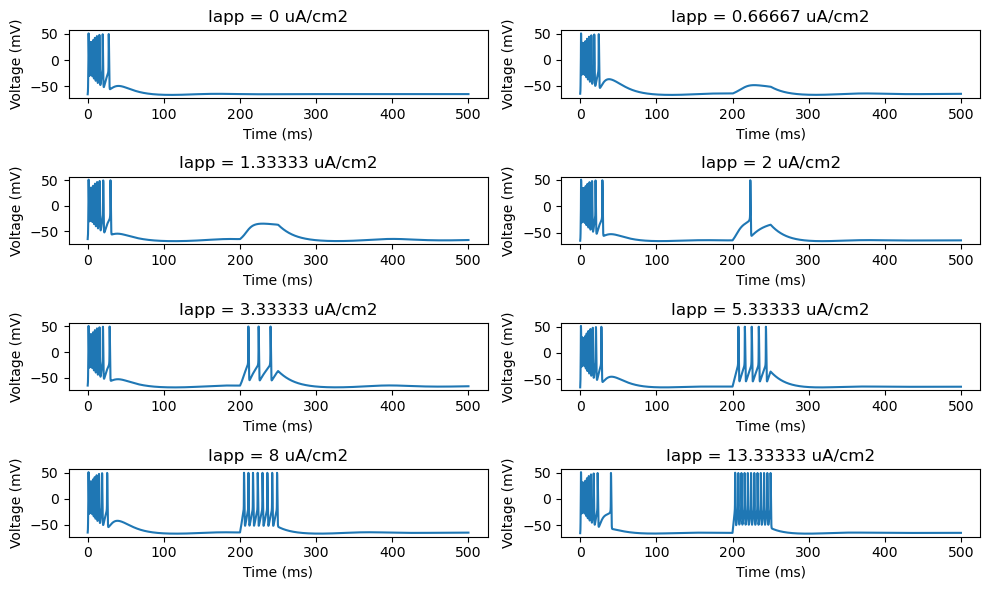

In [5]:
# Run the current injection protocol in a loop and plot the results
fig, axes = plt.subplots(4, 2, figsize=(10, 6))

for i, (I_amp, ax) in enumerate(zip(I_amps, axes.ravel())):  
    
    TC_cells = NeuronGroup(VPM_neuron_num, VPM, threshold = 'v > spike_detect', refractory = 'v > spike_detect', method='rk4')
    TC_cells.v = -65*mV  # Resting potential

    TC_cells.m = 0.05 + 0.1 * np.random.rand(1, VPM_neuron_num)
    TC_cells.h = 0.54 + 0.1 * np.random.rand(1, VPM_neuron_num)
    TC_cells.n = 0.1 * np.random.rand(1, VPM_neuron_num)
    TC_cells.hT = 0.34 + 0.1 * np.random.rand(1, VPM_neuron_num)
    TC_cells.CaBuffer = 0.0001 * np.random.rand(1, VPM_neuron_num)
    TC_cells.o1 = 0 * np.random.rand(1, VPM_neuron_num)
    TC_cells.c1 = 0.5 * np.random.rand(1, VPM_neuron_num)
    TC_cells.p0 = 0.5 * np.random.rand(1, VPM_neuron_num)

    @network_operation(dt=1*ms)
    def update_I():
        TC_cells.Iapp[:VPM_neuron_num] = Istim(defaultclock.t)
   
    # Create a time array for the current input
    times = np.concatenate([np.zeros(start_time), np.ones(stim_ms), np.zeros(end_time - start_time - stim_ms)])
    
    # Create the TimedArray
    Istim = TimedArray(times * (I_amp * uA/cm**2), dt=1*ms)

    # Set up monitors and run the simulation
    M = StateMonitor(TC_cells, variables=['v'], record=True)
    thalamus = Network(TC_cells, M, update_I)
    thalamus.run(end_time*ms)
    
    ax.plot(M.t/ms, M.v[0]/mV)
    ax.set_title(f"Iapp = {I_amp} uA/cm2")
    ax.set_xlabel('Time (ms)')
    ax.set_ylabel('Voltage (mV)')
    
plt.tight_layout()
plt.show()

Thalamic neurons are matching between platforms.

In [6]:
# EXCITATORY CORTICAL NEURONS (parameters)

# Regular-spiking param-values
RS_gleak     = 1.05e-5      * siemens/cm**2
RS_Eleak     = -70.3        * mV
RS_V_T       = -59          * mV
RS_gNa       = 0.086        * siemens/cm**2
RS_gK        = 0.006        * siemens/cm**2
RS_gM        = 15e-5        * siemens/cm**2 
RS_tau_max_M = 808          * ms

EK_ctx = -90    * mV
ENa_ctx = 50    * mV
EM_ctx = -100   * mV

In [7]:
# CORTICAL NEURONS (equations)
CTX = '''
        dv/dt = 1/Cm * (IK + INa + IM + Ileak + Iapp)  : volt
        
        Cm = 1*uF/cm**2 : farad/meter**2
        gleak : siemens/meter**2
        gNa : siemens/meter**2
        gK : siemens/meter**2
        gM  : siemens/meter**2
        Eleak : volt
        V_T : volt
        tau_max_M : second
        Iapp : amp/meter**2
        
        dn/dt = alpha_n * (1-n) - beta_n * n: 1
        dm/dt = alpha_m * (1-m) - beta_m * m : 1
        dh/dt = alpha_h * (1-h) - beta_h * h: 1
        dp/dt = (p_inf - p)/tau_p : 1
        
        alpha_n = -0.0320/mV*(v-V_T-15.0*mV) / (exp( -(v-V_T - 15.0*mV)/(5.0*mV)) - 1) * 1/msecond : Hz
        beta_n = 0.50 * exp( -(v-V_T - 10.0*mV)/(40.0*mV))*1/msecond : Hz
        alpha_m =  -0.32/mV*(v-V_T-13.*mV) / (exp(-(v-V_T-13.*mV)/(4.*mV))-1) * 1/msecond : Hz
        beta_m = ( 0.28/mV * ((v-V_T-40.*mV))) / (exp((v-V_T-40.*mV)/(5.*mV))-1 ) * 1/msecond : Hz
        alpha_h = 0.128 * exp(-(v-V_T-17.*mV)/(18.*mV)) * 1/msecond : Hz
        beta_h = 4./(1.+exp(-(v-V_T-40.*mV)/(5.*mV))) * 1/msecond : Hz
        p_inf = 1 / (1.+exp(-(v+35.*mV)/(10.*mV))) : 1
        tau_p = tau_max_M /( (3.3*exp((v+35.*mV)/(20.*mV)) + exp(-(v+35.*mV)/(20.*mV)))) : second
        
        IK    = -gK * n**4 *(v-EK_ctx) : ampere/meter**2
        INa   = -gNa*m**3*h*(v-ENa_ctx)   : ampere/meter**2
        IM    = -gM *p *(v-EM_ctx)  : ampere/meter**2
        Ileak = -gleak*(v-Eleak): ampere/meter**2
'''

In [8]:
# Create CTX cells

# CELL SIZE
somaDiameter_RS = 61.4 # um

# CELL AREA (neuron as a circle)
A_RS = np.pi*(somaDiameter_RS)**2 * 1e-8 # area of the circle, cm2

E_neuron_num = 1
spike_detect = 0*mV

# Stimulation parameters
start_time = 50
stim_ms = 500
end_time = stim_ms + (2*start_time)


# STEP CURRENT AMPLITUDE
effective_amplitude=np.arange(0, 401, 40); # pA

# RELATIVE CURRENT (effective amplitude is in pA, but Dynasim takes in uA/cm2) 
I_amps=(effective_amplitude*1e-6)/A_RS # [uA/cm2]
# print(I_amps)

WARNING    'Eleak' is an internal variable of group 'neurongroup', but also exists in the run namespace with the value -70. * mvolt. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    'gK' is an internal variable of group 'neurongroup', but also exists in the run namespace with the value 200. * siemens / (meter ** 2). The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    'gNa' is an internal variable of group 'neurongroup', but also exists in the run namespace with the value 900. * siemens / (meter ** 2). The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    'gleak' is an internal variable of group 'neurongroup', but also exists in the run namespace with the value 0.1 * siemens / (meter ** 2). The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    'Eleak' is an internal variable of group 'ne

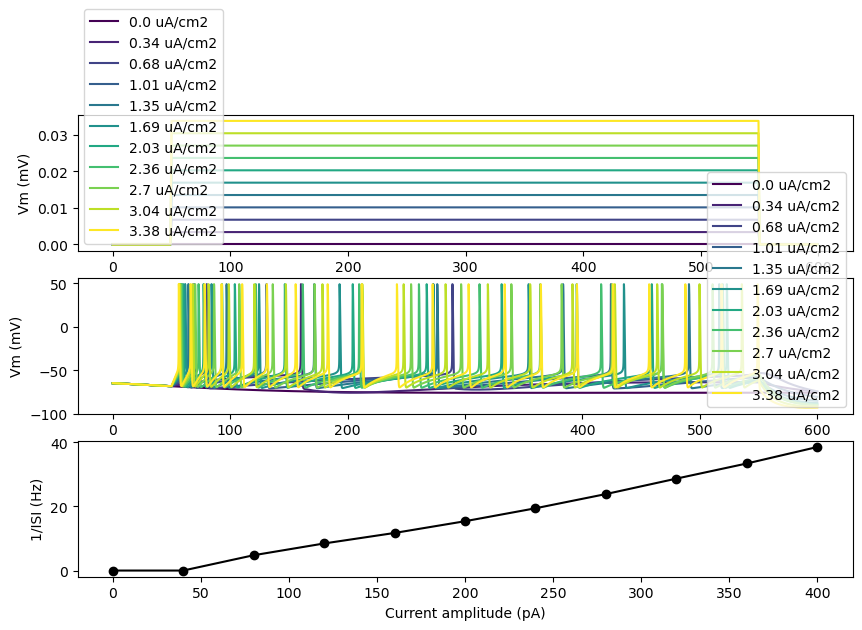

In [10]:
# Run the current injection protocol in a loop and plot the results
# Initialize an empty array to store the results
results_e = np.zeros(size(I_amps))

# Create a list of colors
viridis = plt.get_cmap('viridis', len(results_e))

# Display the colormap
colors = viridis(np.linspace(0, 1, len(results_e)))

figure(figsize=(10, 6))

for idx, I_amp in enumerate(I_amps):  
    
    E_cell = NeuronGroup(E_neuron_num, CTX, threshold = 'v > spike_detect', refractory = 'v > spike_detect', method='rk4')
    E_cell.gleak    =   [RS_gleak]
    E_cell.Eleak    =   [RS_Eleak]
    E_cell.V_T      =   [RS_V_T]
    E_cell.gNa      =   [RS_gNa]
    E_cell.gK       =   [RS_gK]
    E_cell.gM       =   [RS_gM]
    E_cell.tau_max_M =  [RS_tau_max_M]
    E_cell.v        =   [-65] * mV


    @network_operation(dt=1*ms)
    def update_I():
        E_cell.Iapp[:E_neuron_num] = Istim(defaultclock.t)
   
    # Create a time array for the current input
    times = np.concatenate([np.zeros(start_time), np.ones(stim_ms), np.zeros(end_time - start_time - stim_ms)])
    
    # Create the TimedArray
    Istim = TimedArray(times * (I_amp * uA/cm**2), dt=1*ms)

    # Set up monitors and run the simulation
    M = StateMonitor(E_cell, variables=['v'], record=True)
    Spikes = SpikeMonitor(E_cell)
    CTX_e = Network(E_cell, M, Spikes, update_I)
    CTX_e.run(end_time*ms)
    
    spike_times = Spikes.t[Spikes.i == 0]  # Spike times for the neuron
    if len(spike_times) > 1:
        ISI = np.diff(spike_times/second)  # Calculate inter-spike intervals
        FiringRate = 1/(np.mean(ISI)) # Hz
        results_e[idx] = FiringRate
    else:
        results_e[idx] = 0
        
    subplot(311)
    plt.plot(Istim, color=colors[idx], label=f'{round(I_amp,2)} uA/cm2')
    
    subplot(312)
    plt.plot(M.t/ms, M.v[0]/mV, color=colors[idx], label=f'{round(I_amp,2)} uA/cm2')

subplot(311)
plt.legend() # Add legend
plt.xlabel('Time (ms)')
plt.ylabel('Vm (mV)')

subplot(312)
plt.legend() # Add legend
plt.xlabel('Time (ms)')
plt.ylabel('Vm (mV)')

subplot(313)
plt.plot(effective_amplitude,results_e, marker='o', color='k')
plt.xlabel('Current amplitude (pA)')
plt.ylabel('1/ISI (Hz)')

plt.show()

In [11]:
# INHIBITORY CORTICAL NEURONS (parameters)

# Fast-spiking param-values
FS_gleak     = 3.8e-5       * siemens/cm**2
FS_Eleak     = -70.4        * mV
FS_gNa       = 0.078        * siemens/cm**2
FS_V_T       = -58          * mV
FS_gK        = 0.0039       * siemens/cm**2
FS_gM        = 5e-5         * siemens/cm**2
FS_tau_max_M = 602          * ms

EK_ctx = -90    * mV
ENa_ctx = 50    * mV
EM_ctx = -100   * mV

In [12]:
# CELL SIZE
somaDiameter_FS = 56.9 # um

# CELL AREA (neuron as a circle)
A_FS = np.pi*(somaDiameter_FS)**2 * 1e-8 # area of the circle, cm2

I_neuron_num = 1
spike_detect = 0*mV

# Stimulation parameters
start_time = 50
stim_ms = 500
end_time = stim_ms + (2*start_time)


# STEP CURRENT AMPLITUDE
effective_amplitude=np.arange(0, 401, 40); # pA

# RELATIVE CURRENT (effective amplitude is in pA, but Dynasim takes in uA/cm2) 
I_amps=(effective_amplitude*1e-6)/A_FS # [uA/cm2]
# print(I_amps)

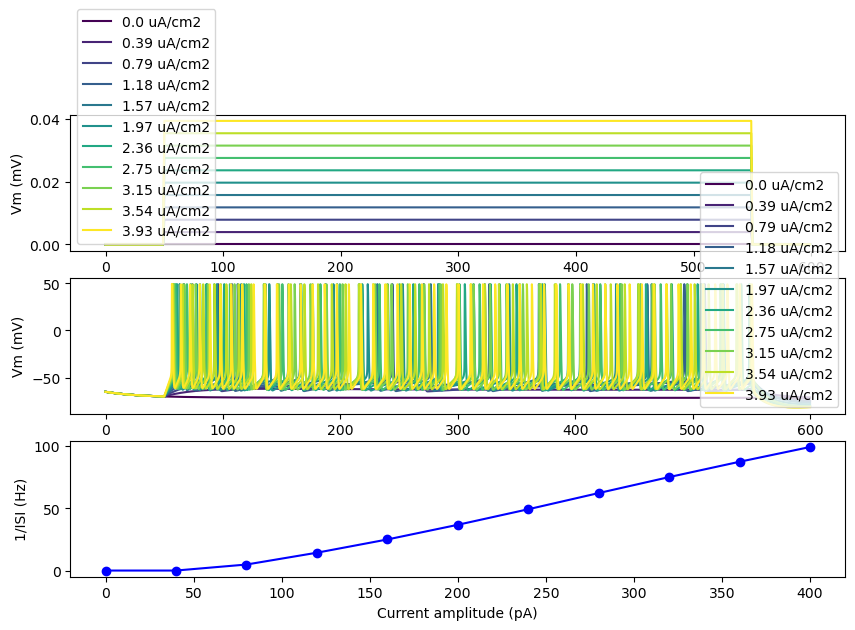

In [13]:
# Run the current injection protocol in a loop and plot the results
# Initialize an empty array to store the results
results_i = np.zeros(size(I_amps))

figure(figsize=(10, 6))

for idx, I_amp in enumerate(I_amps):  
    
    I_cell = NeuronGroup(I_neuron_num, CTX, threshold = 'v > spike_detect', refractory = 'v > spike_detect', method='rk4')
    I_cell.gleak    =   [FS_gleak]
    I_cell.Eleak    =   [FS_Eleak]
    I_cell.V_T      =   [FS_V_T]
    I_cell.gNa      =   [FS_gNa]
    I_cell.gK       =   [FS_gK]
    I_cell.gM       =   [FS_gM]
    I_cell.tau_max_M =  [FS_tau_max_M]
    I_cell.v        =   [-65] * mV


    @network_operation(dt=1*ms)
    def update_I():
        I_cell.Iapp[:I_neuron_num] = Istim(defaultclock.t)
   
    # Create a time array for the current input
    times = np.concatenate([np.zeros(start_time), np.ones(stim_ms), np.zeros(end_time - start_time - stim_ms)])
    
    # Create the TimedArray
    Istim = TimedArray(times * (I_amp * uA/cm**2), dt=1*ms)

    # Set up monitors and run the simulation
    M = StateMonitor(I_cell, variables=['v'], record=True)
    Spikes = SpikeMonitor(I_cell)
    CTX_i = Network(I_cell, M, Spikes, update_I)
    CTX_i.run(end_time*ms)
    
    spike_times = Spikes.t[Spikes.i == 0]  # Spike times for the neuron
    if len(spike_times) > 1:
        ISI = np.diff(spike_times/second)  # Calculate inter-spike intervals
        FiringRate = 1/(np.mean(ISI)) # Hz
        results_i[idx] = FiringRate
    else:
        results_i[idx] = 0
        
    subplot(311)
    plt.plot(Istim, color=colors[idx], label=f'{round(I_amp,2)} uA/cm2')
    
    subplot(312)
    plt.plot(M.t/ms, M.v[0]/mV, color=colors[idx], label=f'{round(I_amp,2)} uA/cm2')

subplot(311)
plt.legend() # Add legend
plt.xlabel('Time (ms)')
plt.ylabel('Vm (mV)')

subplot(312)
plt.legend() # Add legend
plt.xlabel('Time (ms)')
plt.ylabel('Vm (mV)')

subplot(313)
plt.plot(effective_amplitude,results_i, marker='o', color='b')
plt.xlabel('Current amplitude (pA)')
plt.ylabel('1/ISI (Hz)')

plt.show()

(-5.0, 150.0)

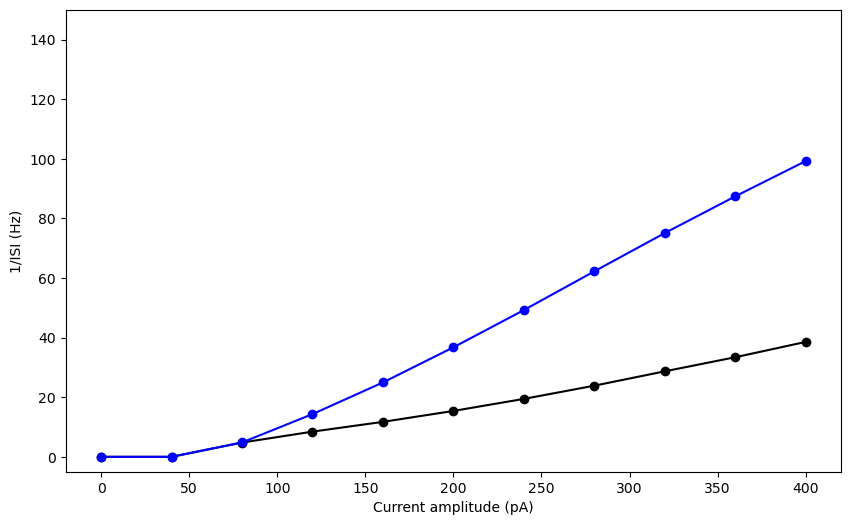

In [14]:
figure(figsize=(10, 6))
plt.plot(effective_amplitude,results_e, marker='o', color='k')
plt.plot(effective_amplitude,results_i, marker='o', color='b')
plt.xlabel('Current amplitude (pA)')
plt.ylabel('1/ISI (Hz)')
plt.ylim(-5, 150)

Cortical input-output transformation is matching.

Task 2: Verify the synaptic connections.

In [15]:
CTX_with_synapse = '''
        dv/dt = 1/Cm * (IK + INa + IM + Ileak + Igaba + Iampa + Iapp)  : volt
        
        gaba2 : 1
        ampa2 : 1
        taud_g : second
        taur_g : second
        slope_g : volt
        gsyn_g : siemens/meter**2
        Esyn_g : volt
        taud_a : second
        taur_a : second
        slope_a : volt
        gsyn_a : siemens/meter**2
        Esyn_a : volt
        
        Cm = 1*uF/cm**2 : farad/meter**2
        gleak : siemens/meter**2
        gNa : siemens/meter**2
        gK : siemens/meter**2
        gM  : siemens/meter**2
        Eleak : volt
        V_T : volt
        tau_max_M : second
        
        dn/dt = alpha_n * (1-n) - beta_n * n: 1
        dm/dt = alpha_m * (1-m) - beta_m * m : 1
        dh/dt = alpha_h * (1-h) - beta_h * h: 1
        dp/dt = (p_inf - p)/tau_p : 1
        
        alpha_n = -0.0320/mV*(v-V_T-15.0*mV) / (exp( -(v-V_T - 15.0*mV)/(5.0*mV)) - 1) * 1/msecond : Hz
        beta_n = 0.50 * exp( -(v-V_T - 10.0*mV)/(40.0*mV))*1/msecond : Hz
        alpha_m =  -0.32/mV*(v-V_T-13.*mV) / (exp(-(v-V_T-13.*mV)/(4.*mV))-1) * 1/msecond : Hz
        beta_m = ( 0.28/mV * ((v-V_T-40.*mV))) / (exp((v-V_T-40.*mV)/(5.*mV))-1 ) * 1/msecond : Hz
        alpha_h = 0.128 * exp(-(v-V_T-17.*mV)/(18.*mV)) * 1/msecond : Hz
        beta_h = 4./(1.+exp(-(v-V_T-40.*mV)/(5.*mV))) * 1/msecond : Hz
        p_inf = 1 / (1.+exp(-(v+35.*mV)/(10.*mV))) : 1
        tau_p = tau_max_M /( (3.3*exp((v+35.*mV)/(20.*mV)) + exp(-(v+35.*mV)/(20.*mV)))) : second
        
        IK    = -gK * n**4 *(v-EK_ctx) : ampere/meter**2
        INa   = -gNa*m**3*h*(v-ENa_ctx)   : ampere/meter**2
        IM    = -gM *p *(v-EM_ctx)  : ampere/meter**2
        Ileak = -gleak*(v-Eleak): ampere/meter**2
        
        dgaba1/dt = -gaba1/taud_g + 1/2 * (1 + (tanh(v/slope_g)))* (1-gaba1)/taur_g : 1 
        dampa1/dt = -ampa1/taud_a + 1/2 * (1 + (tanh(v/slope_a)))* (1-ampa1)/taur_a : 1 

        Igaba = -gsyn_g * gaba2 * (v-Esyn_g): amp/meter**2
        Iampa = -gsyn_a * ampa2 * (v-Esyn_a): amp/meter**2
        Iapp : amp/meter**2
'''

In [40]:
# Neurons
E_cell = NeuronGroup(E_neuron_num, CTX_with_synapse, threshold = 'v > spike_detect', refractory = 'v > spike_detect', method='rk4')
E_cell.gleak    =   [RS_gleak]
E_cell.Eleak    =   [RS_Eleak]
E_cell.V_T      =   [RS_V_T]
E_cell.gNa      =   [RS_gNa]
E_cell.gK       =   [RS_gK]
E_cell.gM       =   [RS_gM]
E_cell.tau_max_M =  [RS_tau_max_M]
E_cell.v        =   [-65] * mV

I_cell = NeuronGroup(I_neuron_num, CTX_with_synapse, threshold = 'v > spike_detect', refractory = 'v > spike_detect', method='rk4')
I_cell.gleak    =   [FS_gleak]
I_cell.Eleak    =   [FS_Eleak]
I_cell.V_T      =   [FS_V_T]
I_cell.gNa      =   [FS_gNa]
I_cell.gK       =   [FS_gK]
I_cell.gM       =   [FS_gM]
I_cell.tau_max_M =  [FS_tau_max_M]
I_cell.v        =   [-65] * mV
    
    
# Synapses

# AMPA params
Esyn_AMPA = 0       * mV  
gsyn_AMPA = 0.1 * 0.17    * msiemens/cm**2
slope_AMPA = 10     * mvolt
taud_AMPA = 2       * ms
taur_AMPA = 0.1     * ms

# GABA params
Esyn_GABA = -80         * mV 
gsyn_GABA = 0.25 * 0.5   * msiemens/cm**2 
taud_GABA = 10      * ms
taur_GABA = 0.2     * ms
slope_GABA = 10     * mvolt

# Define dynamics
EI = Synapses(E_cell, I_cell, on_pre = 'ampa2_post = 7.9 * ampa1_pre') # weight is 1
# IE = Synapses(I_cell, E_cell, on_pre = 'gaba2_post = 16 * gaba1_pre')
EI.connect(p=1)
# IE.connect(p=1)

E_cell.taud_g     = [taud_GABA]
E_cell.taur_g     = [taur_GABA]
E_cell.slope_g    = [slope_GABA]
E_cell.gsyn_g     = [gsyn_GABA]
E_cell.Esyn_g     = [Esyn_GABA]
E_cell.gaba2       = [0]
E_cell.taud_a     = [taud_AMPA]
E_cell.taur_a     = [taur_AMPA]
E_cell.slope_a    = [slope_AMPA]
E_cell.gsyn_a     = [gsyn_AMPA]
E_cell.Esyn_a     = [Esyn_AMPA]
E_cell.ampa2       = [0]

I_cell.taud_g     = [taud_GABA]
I_cell.taur_g     = [taur_GABA]
I_cell.slope_g    = [slope_GABA]
I_cell.gsyn_g     = [gsyn_GABA]
I_cell.Esyn_g     = [Esyn_GABA]
I_cell.gaba2       = [0]
I_cell.taud_a     = [taud_AMPA]
I_cell.taur_a     = [taur_AMPA]
I_cell.slope_a    = [slope_AMPA]
I_cell.gsyn_a     = [gsyn_AMPA]
I_cell.Esyn_a     = [Esyn_AMPA]
I_cell.ampa2       = [0]

WARNING    Came across an abstract code block that may not be well-defined: the outcome may depend on the order of execution. You can ignore this warning if you are sure that the order of operations does not matter. Abstract code: 'ampa2_post = 7.9 * ampa1_pre'
 [brian2.codegen.generators.base]


Text(0.5, 0, 'Time (ms)')

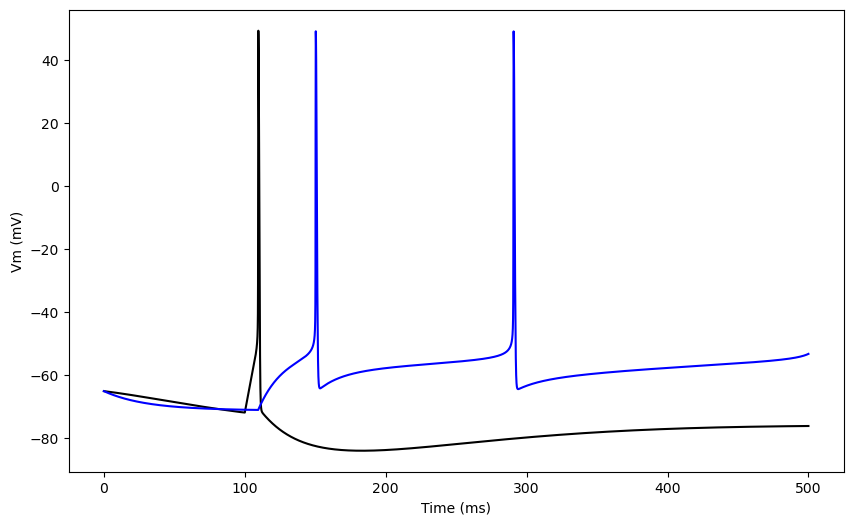

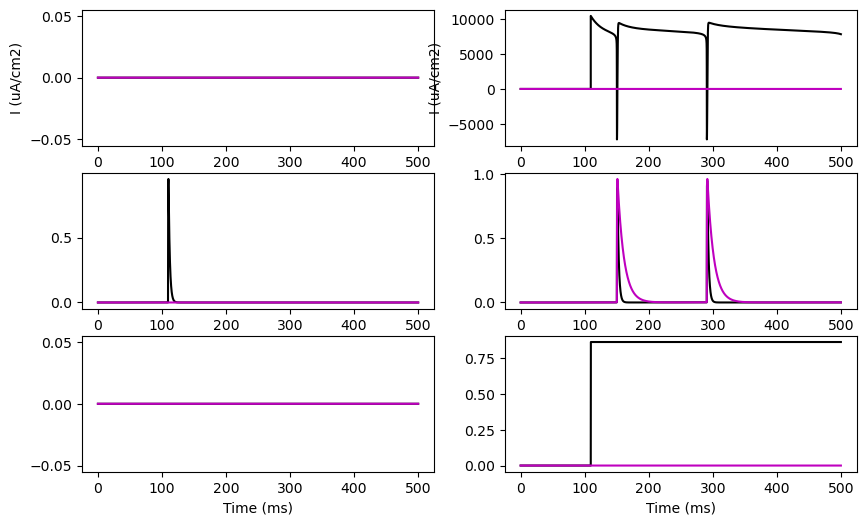

In [41]:
########### Input ###########
I_amp = 2.5

# Stimulation parameters
end_time = 500

times = np.concatenate([np.zeros(100), np.ones(10), np.zeros(end_time - 100 - 10)])
Istim_e = TimedArray(times * (I_amp * uA/cm**2), dt=1*ms)

# times = np.concatenate([np.zeros(300), np.ones(10), np.zeros(end_time - 300 - 10)])
# Istim_i = TimedArray(times * (I_amp * uA/cm**2), dt=1*ms)

@network_operation(dt=1*ms)
def update_I():
    E_cell.Iapp[:E_neuron_num] = Istim_e(defaultclock.t)
#     I_cell.Iapp[:I_neuron_num] = Istim_i(defaultclock.t)

# Set up monitors and run the simulation
M_e = StateMonitor(E_cell, variables=['v', 'Iampa', 'Igaba', 'ampa1', 'ampa2', 'gaba1', 'gaba2'], record=True)
M_i = StateMonitor(I_cell, variables=['v', 'Iampa', 'Igaba', 'ampa1', 'ampa2', 'gaba1', 'gaba2'], record=True)

CTX_twoNeurons = Network(E_cell, I_cell, EI, M_e, M_i, update_I)
CTX_twoNeurons.run(end_time*ms)

figure(figsize=(10, 6))
plt.plot(M_e.t/ms, M_e.v[0]/mV, color='k')
plt.plot(M_i.t/ms, M_i.v[0]/mV, color='b')
plt.ylabel('Vm (mV)')
plt.xlabel('Time (ms)')

figure(figsize=(10, 6))
subplot(321)
plt.plot(M_e.t/ms, M_e.Iampa[0]/(uA/meter**2), color='k')
plt.plot(M_e.t/ms, M_e.Igaba[0]/(uA/meter**2), color='m')
plt.ylabel('I (uA/cm2)')
plt.xlabel('Time (ms)')

subplot(323)
plt.plot(M_e.t/ms, M_e.ampa1[0], color='k')
plt.plot(M_e.t/ms, M_e.gaba2[0], color='m')
plt.xlabel('Time (ms)')

subplot(325)
plt.plot(M_e.t/ms, M_e.ampa2[0], color='k')
plt.plot(M_e.t/ms, M_e.gaba2[0], color='m')
plt.xlabel('Time (ms)')

subplot(322)
plt.plot(M_i.t/ms, M_i.Iampa[0]/(uA/meter**2), color='k')
plt.plot(M_i.t/ms, M_i.Igaba[0]/(uA/meter**2), color='m')
plt.ylabel('I (uA/cm2)')
plt.xlabel('Time (ms)')

subplot(324)
plt.plot(M_i.t/ms, M_i.ampa1[0], color='k')
plt.plot(M_i.t/ms, M_i.gaba1[0], color='m')
plt.xlabel('Time (ms)')

subplot(326)
plt.plot(M_i.t/ms, M_i.ampa2[0], color='k')
plt.plot(M_i.t/ms, M_i.gaba2[0], color='m')
plt.xlabel('Time (ms)')